In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Read all data files of all categories.
import os

trajectories_per_category = {}
categories = ['alive', 'plastic', 'fibro']
downsample_steps = {'alive': 2, 'fibro': 5, 'plastic': 5}  # TODO: Rename var.

for category in categories:
    data_dir = 'data/JulianTrajs/' + category
    trajectories_per_category[category] = []  # dimensions: trajectory index -> time step -> coordinate (x, y, z)
    filenames = os.listdir(data_dir)
    for filename in filenames:
        trajectory = np.genfromtxt(os.path.join(data_dir, filename))
        trajectories_per_category[category].append(trajectory[::downsample_steps[category]])
    trajectories_per_category[category] = np.array(trajectories_per_category[category])
    print "Category {}: Found {} files, created {} trajectories".format(category, len(filenames), len(trajectories_per_category[category]))

Category alive: Found 65 files, created 65 trajectories
Category plastic: Found 177 files, created 177 trajectories
Category fibro: Found 69 files, created 69 trajectories


In [3]:
# Convert to velocities (um / min).
for category in trajectories_per_category:
    trajectories_per_category[category] = np.diff(trajectories_per_category[category], axis=1) / 5.

In [4]:
# Normalize trajectories to [-1, 1] for the LSTM network (it outputs values between -1 and 1 by default).
min_value = np.min([np.min(traj) for traj in trajectories_per_category.values()])
max_value = np.max([np.max(traj) for traj in trajectories_per_category.values()])
for category in trajectories_per_category:
    trajectories_per_category[category] = np.interp(trajectories_per_category[category], [min_value, max_value], [-1., 1.])

In [5]:
def split(arr, fraction):
    index_to_split = int(np.rint(fraction * len(arr)))
    return arr[:index_to_split], arr[index_to_split:]

In [6]:
training_trajectories_per_category = {}
test_trajectories_per_category = {}
for category in categories:
    test_trajectories_per_category[category], training_trajectories_per_category[category] = split(trajectories_per_category[category], 0.2)

In [7]:
test_trajectories_per_category['alive'].shape

(13, 288, 3)

In [8]:
def shuffle_together(*args):
    rng_state = np.random.get_state()
    for arg in args:
        np.random.shuffle(arg)
        np.random.set_state(rng_state)

In [9]:
category_to_target = {'alive': 0, 'fibro': 1, 'plastic': 2}
target_to_category = {0: 'alive', 1: 'fibro', 2: 'plastic'}

def create_mini_trajectories(traj_per_category, length, step):
    
    mini_trajectories_per_category = {}
    
    for category in traj_per_category:
        mini_trajectories_per_category[category] = []

        for trajectory in traj_per_category[category]:
            for i in range(0, len(trajectory) - length, step):
                mini_trajectories_per_category[category].append(trajectory[i:i+length])

        print 'Created {} mini trajectories for {}'.format(len(mini_trajectories_per_category[category]), category)
    
    mini_trajectories = []
    classes = []
    for category, mini_traj in mini_trajectories_per_category.items():
        np.random.shuffle(mini_traj)
        mini_trajectories.extend(mini_traj)
        classes.extend([category_to_target[category]] * len(mini_traj))

    mini_trajectories = np.array(mini_trajectories)
    classes = np.array(classes)
    from keras.utils import np_utils
    targets = np_utils.to_categorical(classes, 3)

    shuffle_together(mini_trajectories, classes, targets)
    print 'Total: {} mini trajectories'.format(len(mini_trajectories))
    
    return mini_trajectories, classes, targets

In [10]:
len_mini_trajectories = 30
step = 5
training_mini_trajectories, training_classes, training_targets = create_mini_trajectories(training_trajectories_per_category, len_mini_trajectories, step)
test_mini_trajectories, test_classes, test_targets = create_mini_trajectories(test_trajectories_per_category, len_mini_trajectories, step)

Created 1870 mini trajectories for fibro
Created 2704 mini trajectories for alive
Created 4828 mini trajectories for plastic
Total: 9402 mini trajectories
Created 476 mini trajectories for fibro
Created 676 mini trajectories for alive
Created 1190 mini trajectories for plastic
Total: 2342 mini trajectories


In [11]:
class_weights = {}
for which_class in [0, 1, 2]:
    class_weights[which_class] = 1. / np.sum(training_classes == which_class)
class_weights

{0: 0.0003698224852071006, 1: 0.0005347593582887701, 2: 0.00020712510356255177}

In [12]:
# Set up the network.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(input_dim=3, output_dim=10, return_sequences=False))
#model.add(LSTM(output_dim=10, return_sequences=False))
#model.add(LSTM(output_dim=30, return_sequences=False))
model.add(Dense(output_dim=3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Using Theano backend.
D:\Python\27_32bit\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [13]:
# Callback to evaluate accuracy for each class during training. 
from keras.callbacks import Callback
class ClassHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc_per_category = {'alive': [], 'fibro': [], 'plastic': []}
        self.val_acc_per_category = {'alive': [], 'fibro': [], 'plastic': []}
        
    def on_epoch_end(self, epoch, logs={}):
        training_predicted = self.model.predict_classes(training_mini_trajectories, verbose=0)
        test_predicted = self.model.predict_classes(test_mini_trajectories, verbose=0)
        for category in categories:
            which_class = category_to_target[category]
            acc = 1. * np.sum(training_predicted[training_classes == which_class] == which_class) / len(training_predicted[training_classes == which_class])
            val_acc = 1. * np.sum(test_predicted[test_classes == which_class] == which_class) / len(test_predicted[test_classes == which_class])
            self.acc_per_category[category].append(acc)
            self.val_acc_per_category[category].append(val_acc)
            
            
history_per_category = ClassHistory()

In [ ]:
accs = []
accs_per_category = {'alive': [], 'fibro': [], 'plastic': []}
val_accs = []

In [ ]:
hist = model.fit(training_mini_trajectories, training_targets, 
                 batch_size=15, nb_epoch=100, 
                 verbose=1, show_accuracy=True, validation_data=(test_mini_trajectories, test_targets), callbacks=[history_per_category])

accs.extend(hist.history['acc'])
val_accs.extend(hist.history['val_acc'])
for category in accs_per_category:
    accs_per_category[category].extend(history_per_category.acc_per_category[category])

Train on 9402 samples, validate on 2342 samples
Epoch 1/100
9402/9402 [==============================] - 9s - loss: 1.0249 - acc: 0.5129 - val_loss: 1.0231 - val_acc: 0.5081
Epoch 2/100
9402/9402 [==============================] - 10s - loss: 1.0169 - acc: 0.5155 - val_loss: 1.0153 - val_acc: 0.5141
Epoch 3/100
5760/9402 [=================>............] - ETA: 5s - loss: 1.0133 - acc: 0.5165

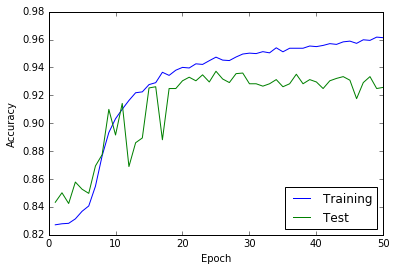

In [114]:
# Plot accuracy over epochs.
plt.plot(range(1, len(accs) + 1), accs, label='Training')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#plt.xlim(60, 100)
#plt.ylim(0.9, 1)

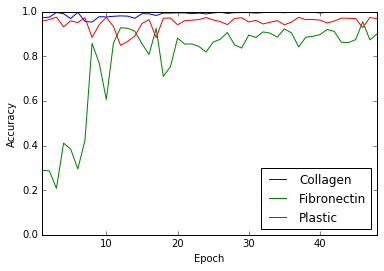

In [115]:
# Plot accuracy over epochs for each class.
names = {'alive': 'Collagen', 'fibro': 'Fibronectin', 'plastic': 'Plastic'}

#plt.plot(range(1, len(accs) + 1), accs, 'k', label='Overall')

for category in ['alive', 'fibro', 'plastic']:
    plt.plot(range(1, len(accs_per_category[category]) - 1), accs_per_category[category][:-2], '-', label=names[category])
    
plt.ylim(0, 1)
plt.xlim(1, len(accs_per_category['alive'])-2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#plt.savefig('plots/classes.png', dpi=300)

Class 0: 0.000
Class 1: 0.002
Class 2: 0.998
Is Class 2


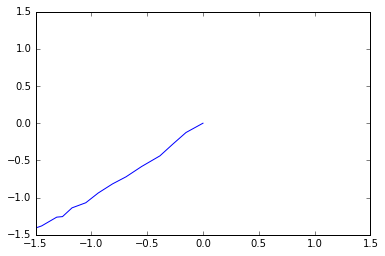

In [22]:
# Test on a random mini trajectory from the test dataset.
i = np.random.randint(len(test_mini_trajectories))
# TODO: Check if this is correct; most trajectories seem to go to the top right.
reconstructed_trajectory = np.cumsum(test_mini_trajectories[i], axis=0) - test_mini_trajectories[i, 0]
plt.plot(reconstructed_trajectory[:, 0], reconstructed_trajectory[:, 1])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

probabilities, = model.predict(test_mini_trajectories[i:i+1])

for cat, prob in enumerate(probabilities):    
    print 'Class {}: {:.3f}'.format(cat, prob)    
        
print 'Is Class', test_classes[i]

In [72]:
# Evaluate accuracy for each class. 
training_predicted = model.predict_classes(training_mini_trajectories, verbose=0)
test_predicted = model.predict_classes(test_mini_trajectories, verbose=0)

training_acc = 1. * np.sum(training_predicted == training_classes) / len(training_predicted)
test_acc = 1. * np.sum(test_predicted == test_classes) / len(test_predicted)
print 'Overall accuracy:               Training: {:.3f}, Test: {:.3f}'.format(training_acc, test_acc)

for which_class in [0, 1, 2]:
    training_acc = 1. * np.sum(training_predicted[training_classes == which_class] == which_class) / len(training_predicted[training_classes == which_class])
    test_acc = 1. * np.sum(test_predicted[test_classes == which_class] == which_class) / len(test_predicted[test_classes == which_class])
    print 'Accuracy for class {} ({:^7}): Training: {:.3f}, Test: {:.3f}'.format(which_class, target_to_category[which_class], training_acc, test_acc)

Overall accuracy:               Training: 0.946, Test: 0.936
Accuracy for class 0 ( alive ): Training: 0.991, Test: 1.000
Accuracy for class 1 ( fibro ): Training: 0.827, Test: 0.803
Accuracy for class 2 (plastic): Training: 0.967, Test: 0.953


In [116]:
# Evaluate accuracy for trajectories of different lengths (ie with different numbers of time steps).

# According to the RBM thesis, the data should be correlated for 3 to 7 (corrected) time steps. 
# See details for each category in the thesis - can we replicate this with the NN?

#mini_trajectories_per_length = {}
len_accs_per_category = {'alive': [], 'fibro': [], 'plastic': []}
lengths = range(2, 120, 5)
for length in lengths:
    # TODO: Use training or test here?
    mini_trajectories, classes, targets = create_mini_trajectories(test_trajectories_per_category, length, int(max(1., length / 5.)))
    predicted = model.predict_classes(mini_trajectories, verbose=0)
    for category in categories:
        which_class = category_to_target[category]
        acc = 1. * np.sum(predicted[classes == which_class] == which_class) / len(predicted[classes == which_class])
        len_accs_per_category[category].append(acc)

# TODO: Make plot of raw probabilities over trajectory length.

Created 2758 mini trajectories for fibro
Created 3718 mini trajectories for alive
Created 6895 mini trajectories for plastic
Total: 13371 mini trajectories
Created 2688 mini trajectories for fibro
Created 3653 mini trajectories for alive
Created 6720 mini trajectories for plastic
Total: 13061 mini trajectories
Created 1316 mini trajectories for fibro
Created 1794 mini trajectories for alive
Created 3290 mini trajectories for plastic
Total: 6400 mini trajectories
Created 854 mini trajectories for fibro
Created 1183 mini trajectories for alive
Created 2135 mini trajectories for plastic
Total: 4172 mini trajectories
Created 630 mini trajectories for fibro
Created 871 mini trajectories for alive
Created 1575 mini trajectories for plastic
Total: 3076 mini trajectories
Created 490 mini trajectories for fibro
Created 689 mini trajectories for alive
Created 1225 mini trajectories for plastic
Total: 2404 mini trajectories
Created 392 mini trajectories for fibro
Created 559 mini trajectories for

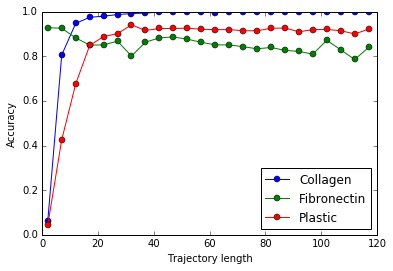

In [117]:
for category in ['alive', 'fibro', 'plastic']:
    plt.plot(lengths, len_accs_per_category[category], 'o-', label=names[category])
plt.xlabel('Trajectory length')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right', numpoints=1)

#plt.savefig('plots/length.png', dpi=300)

In [ ]:
# Possible parameters for future hyperparemeter optimzation:
# - mini trajectory length
# - mini trajectory step
# - output_dim
# - number of LSTM layers
# - rmsprop parameters
# - batch_size
# - activation/internal parameters of LSTM

In [ ]:
# Save model to file.
open('model/my_model_architecture.json', 'w').write(model.to_json())
model.save_weights('model/my_model_weights.h5')

In [ ]:
# Load model from file.
from keras.models import model_from_json
model = model_from_json(open('model/my_model_architecture.json').read())
model.load_weights('model/my_model_weights.h5')